In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
csv_path = "1_Daily_minimum_temps.csv"  # pastikan file ini ada di folder proyek
df = pd.read_csv(csv_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
print("Dataset loaded:", df.shape)
display(df.head())

C:\Users\plstk\AppData\Local\Temp\ipykernel_9260\3428805897.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Dataset loaded: (3650, 1)


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


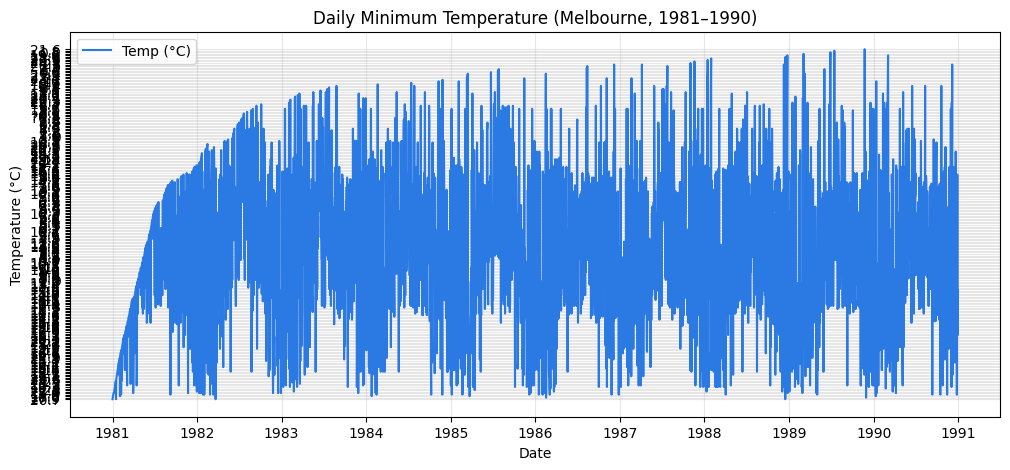

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df['Temp'], label='Temp (°C)', color='#2B7AE4')  # biru muda
plt.title('Daily Minimum Temperature (Melbourne, 1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [5]:
print("Missing values:\n", df.isnull().sum())
print("\nDescriptive stats:\n", df.describe())

Missing values:
 Temp    0
dtype: int64

Descriptive stats:
         Temp
count   3650
unique   230
top       10
freq      51


In [10]:
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df = df.dropna(subset=['Temp'])
series = df['Temp'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series)
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved -> scaler.pkl")

Scaler saved -> scaler.pkl


In [12]:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(series_scaled, window_size=window_size)
print("X shape:", X.shape, "y shape:", y.shape)

X = X.reshape((X.shape[0], X.shape[1], 1))

X shape: (3617, 30, 1) y shape: (3617, 1)


In [13]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

Train samples: 2893 Test samples: 724


In [14]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\plstk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint_filepath = "best_model_temp.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0286

154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0285 - val_loss: 0.0121
Epoch 2/10
152/154 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0138

154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0130

154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0127

154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0127 - val_loss: 0.0116
Epoch 5/10
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0122

154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 6/10
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0119

154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0115

154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 10/10
153/154 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0111

154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0111 - val_loss: 0.0105


In [16]:
model.save("model_lstm.h5")
print("Model saved -> model_lstm.h5")

Model saved -> model_lstm.h5


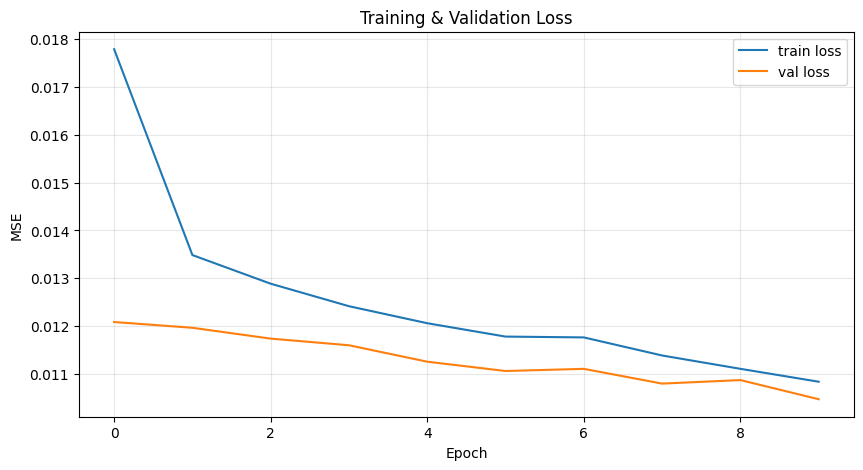

In [17]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [18]:
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Test RMSE: {rmse:.4f} °C")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Test RMSE: 2.4292 °C


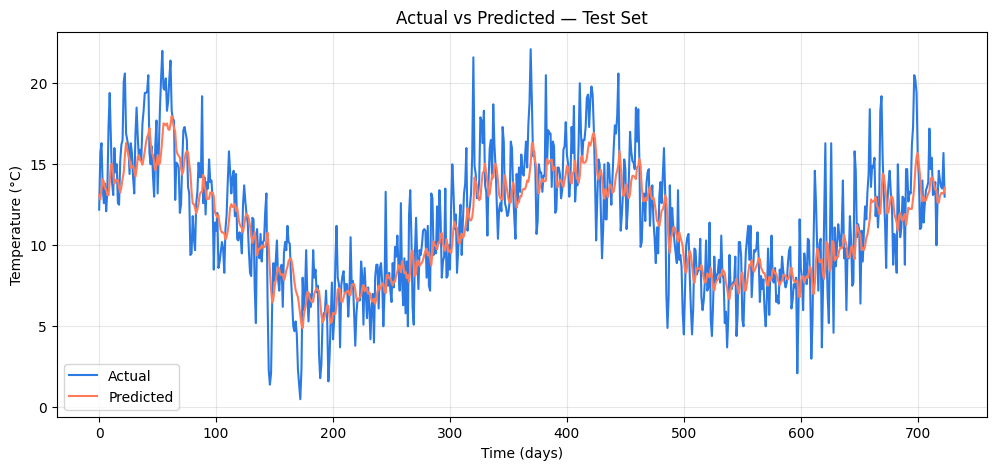

In [19]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual', color='#2B7AE4')
plt.plot(y_pred_inv, label='Predicted', color='#FF7A59')
plt.title('Actual vs Predicted — Test Set')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [20]:
last_window = series_scaled[-window_size:].reshape(1, window_size, 1)
next_pred_scaled = model.predict(last_window)
next_pred = scaler.inverse_transform(next_pred_scaled).flatten()[0]
print(f"Prediksi suhu hari berikutnya: {next_pred:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediksi suhu hari berikutnya: 13.31 °C


In [21]:
with open("model_report.txt", "w") as f:
    f.write(f"Window size: {window_size}\n")
    f.write(f"Train samples: {X_train.shape[0]}\n")
    f.write(f"Test samples: {X_test.shape[0]}\n")
    f.write(f"Test RMSE: {rmse:.4f}\n")
    f.write(f"Next day pred (°C): {next_pred:.4f}\n")
print("Report -> model_report.txt")

Report -> model_report.txt
